#Steady State Solutions

###Contents
- [Introduction](#intro)
- [Steady State Solvers](#steady)
- [Using the Steady State Solvers](#using)
- [Additional Solver Arguments](#args)
- [Example: Harmonic Oscillator in Thermal Bath](#example)

In [5]:
%matplotlib inline
import numpy as np
from pylab import *
from qutip import *

<a id='intro'></a>

##Introduction

For time-independent open quantum systems with decay rates larger than the corresponding excitation rates, the system will tend toward a steady state as $t\rightarrow\infty$ that satisfies the equation

$$\frac{d\hat{\rho}_{ss}}{dt}=\mathcal{L}\hat{\rho}_{ss}=0.$$

Although the requirement for time-independence seems quite restrictive, one can often employ a transformation to the interaction picture that yields a time-independent Hamiltonian.  For many these systems, solving for the asymptotic density matrix $\hat{\rho}_{ss}$ can be achieved using direct or iterative solution methods faster than using master equation or Monte Carlo simulations.  Although the steady state equation has a simple mathematical form, the non-symmetric structure of the Liouvillian operator are such that efficient solutions to this equation are anything but straightforward to find.

<a id='steady'></a>

Steady State solvers in QuTiP
============================= 
In QuTiP, the steady-state solution for a system Hamiltonian or Liouvillian is given by `steadystate`.  This function implements a number of different methods for finding the steady state, each with their own pros and cons, where the method used can be chosen using the ``method`` keyword argument. 

<table>
  <tr>
    <th>Method</th>
    <th>Keyword</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Direct (default)</td>
    <td>'direct'</td>
    <td>Direct solution solving $Ax=b$ via sparse LU decomposition.</td>
  </tr>
  <tr>
    <td>Eigenvalue</td>
    <td>'eigen'</td>
    <td>Iteratively find the eigenvector corresponding to the zero eigenvalue of $\mathcal{L}$.</td>
  </tr>
  <tr>
    <td>Inverse-Power</td>
    <td>'power'</td>
    <td>Iteratively solve for the steady-state solution using the inverse-power method.</td>
  </tr>
  <tr>
    <td>GMRES</td>
    <td>'iterative-gmres'</td>
    <td>Iteratively solve for the steady-state solution using the GMRES method and optional preconditioner.</td>
  </tr>
  <tr>
    <td>LGMRES</td>
    <td>'iterative-lgmres'</td>
    <td>Iteratively solve for the steady-state solution using the LGMRES method and optional preconditioner.</td>
  </tr>
  <tr>
    <td>BICGSTAB</td>
    <td>'iterative-bicgstab'</td>
    <td>Iteratively solve for the steady-state solution using the BICGSTAB method and optional preconditioner.</td>
  </tr>
  <tr>
    <td>SVD</td>
    <td>'svd'</td>
    <td>Steady-state solution via the SVD of the Liouvillian represented by a **dense** matrix.</td>
  </tr>
  <tr>
    <td>Power GMRES</td>
    <td>'power-gmres'</td>
    <td>Solution using a doubly-iterative inverse-power method using GMRES iteration and optional preconditioner.</td>
  </tr>
  <tr>
    <td>Power LGMRES</td>
    <td>'power-lgmres'</td>
    <td>Solution using a doubly-iterative inverse-power method using LGMRES iteration and optional preconditioner.</td>
  </tr>
  <tr>
    <td>Power BICGSTAB</td>
    <td>'power-bicgstab'</td>
    <td>Solution using a doubly-iterative inverse-power method using BICGSTAB iteration and optional preconditioner.</td>
  </tr>
</table>


The function `steadystate` can take either a Hamiltonian and a list of collapse operators as input, generating internally the corresponding Liouvillian super operator in Lindblad form, or alternatively, an arbitrary Liouvillian passed by the user. When possible, we recommend passing the Hamiltonian and collapse operators to `steadystate`, and letting the function automatically build the Liouvillian for the system.

<a id='using'></a>

##Using the Steadystate Solver

Solving for the steady state solution to the Lindblad master equation for a general system with `steadystate` can be accomplished using:
```python
rho_ss = steadystate(H, c_ops)
```
where ``H`` is a quantum object representing the system Hamiltonian, and ``c_ops`` is a list of quantum objects for the system collapse operators. The output, labeled as ``rho_ss``, is the steady-state solution for the systems.  If no other keywords are passed to the solver, the default 'direct' method is used, generating a solution that is exact to machine precision at the expense of a large memory requirement.  The large amount of memory need for the direct LU decomposition method stems from the large bandwidth of the system Liouvillian and the correspondingly large fill-in (extra nonzero elements) generated in the LU factors.  This fill-in can be reduced by using bandwidth minimization algorithms.  Additional parameters may be used by calling the steady-state solver as:
```python
rho_ss = steadystate(H, c_ops, method='power', use_rcm=True)
```
where ``method='power'`` indicates that we are using the inverse-power solution method, and ``use_rcm=True`` turns on the bandwidth minimization routine.  


Although it is not obvious, the ``'direct'``, ``eigen``, and ``'power'`` methods all use an LU decomposition internally and thus suffer from a large memory overhead.  In contrast, iterative methods such as the ``'iterative-gmres'``, ``'iterative-lgmres'``, and ``'iterative-bicgstab'`` methods do not factor the matrix and thus take less memory than these previous methods and allowing, in principle, for extremely large system sizes. The downside is that these methods can take much longer than the direct method as the condition number of the Liouvillian matrix is large, indicating that these iterative methods require a large number of iterations for convergence.  To overcome this, one can use a preconditioner $M$ that solves for an approximate inverse for the (modified) Liouvillian, thus better conditioning the problem, leading to faster convergence.  The use of a preconditioner can actually make these iterative methods faster than the other solution methods.  The problem with precondioning is that it is only well defined for Hermitian matrices.  Since the Liouvillian is non-Hermitian, the ability to find a good preconditioner is not guaranteed.  And moreover, if a preconditioner is found, it is not guaranteed to have a good condition number. QuTiP can make use of an incomplete LU preconditioner when using the iterative ``'gmres'``, ``'lgmres'``, and ``'bicgstab'`` solvers by setting ``use_precond=True``. The preconditioner optionally makes use of a combination of symmetric and anti-symmetric matrix permutations that attempt to improve the preconditioning process.  These features are discussed in the [Additional Solver Arguments](#args) section.  Even with these state-of-the-art permutations, the generation of a successful preconditoner for non-symmetric matrices is currently a trial-and-error process due to the lack of mathematical work done in this area.  It is always recommended to begin with the direct solver with no additional arguments before selecting a different method.

Finding the steady-state solution is not limited to the Lindblad form of the master equation. Any time-independent Liouvillian constructed from a Hamiltonian and collapse operators can be used as an input:
```python
rho_ss = steadystate(L)
```
where ``L`` is the Louvillian.  All of the additional arguments can also be used in this case.

<a id='args'></a>

##Additional Solver Arguments

The following additional solver arguments are available for the steady-state solver:

<table>
  <tr>
    <th>Keyword</th>
    <th>Options (default listed first)</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>method</td>
    <td>'direct', 'eigen', 'power', 'iterative-gmres','iterative-lgmres', 'svd', 'power-gmres', 'power-lgmres', 'power-bicgstab'</td>
    <td>Method used for solving for the steady-state density matrix.</td>
  </tr>
  <tr>
    <td>sparse</td>
    <td>True, False</td>
    <td>Use sparse version of direct solver.</td>
  </tr>
  <tr>
    <td>return_info</td>
    <td>False, True</td>
    <td>Return a dictionary of solver-specific information about the solution and how it was obtained.</td>
  </tr>
  <tr>
    <td>weight</td>
    <td>None</td>
    <td>Allows the user to define the weighting factor used in the 'direct', 'iterative-gmres', 'iterative-lgmres', and 'iterative-bicgstab' solvers.</td>
  </tr>
  <tr>
    <td>tol</td>
    <td>1e-12</td>
    <td>Tolerance used in finding the solution for all methods expect ``'direct'`` and ``'svd'``.</td>
  </tr>
  <tr>
    <td>permc_spec</td>
    <td>'COLAMD', 'NATURAL'</td>
    <td>Ordering used for the sparse LU decomposition.</td>
  </tr>
  <tr>
    <td>use_rcm</td>
    <td>False, True</td>
    <td>Use a Reverse Cuthill-Mckee reordering to minimize the bandwidth of the modified Liouvillian used in the LU decomposition. If ``use_rcm=True`` then the column ordering is set to ``'Natural'`` automatically unless explicitly set.</td>
  </tr>
  <tr>
    <td>use_wbm</td>
    <td>False, True</td>
    <td>Use a Weighted Bipartite Matching algorithm to attempt to make the modified Liouvillian more diagonally dominate, and thus for favorable for preconditioning.</td>
  </tr>
  <tr>
    <td>use_umfpack</td>
    <td>False, True</td>
    <td>Use the umfpack solver rather than the default superLU. In SciPy 0.14+, this option requires installing the scikits.umfpack extension.</td>
  </tr>
  <tr>
    <td>use_precond</td>
    <td>False, True</td>
    <td>Attempt to generate a preconditioner when using the ``'iterative-gmres'``, ``'iterative-lgmres'``, and ``'iterative-bicgstab'`` methods.</td>
  </tr>
  <tr>
    <td>M</td>
    <td>None, sparse_matrix, LinearOperator</td>
    <td>A user defined preconditioner, if any.</td>
  </tr>
  <tr>
    <td>maxiter</td>
    <td>1000</td>
    <td>Maximum number of iterations to perform for all methods expect ``'direct'`` and ``'svd'``.</td>
  </tr>
  <tr>
    <td>fill_factor</td>
    <td>100</td>
    <td>Upper-bound on the allowed fill-in for the approximate inverse preconditioner.,This value may need to be set much higher than this in many cases.</td>
  </tr>
  <tr>
    <td>drop_tol</td>
    <td>1e-4</td>
    <td>Sets the threshold for the relative magnitude of preconditioner elements that should be dropped. A lower number yields a more accurate approximate inverse at the expense of fill-in and increased runtime.</td>
  </tr>
  <tr>
    <td>diag_pivot_thresh</td>
    <td>None</td>
    <td>Sets the threshold between $[0,1]$ for which diagonal elements are considered acceptable pivot points when using a preconditioner.</td>
  </tr>
  <tr>
    <td>x0</td>
    <td>None</td>
    <td>Optional guess for initial solution vector.</td>
  </tr>
  <tr>
    <td>restart</td>
    <td>20</td>
    <td>Number of iterations before GMRES restarts.</td>
  </tr>
  <tr>
    <td>ILU_MILU</td>
    <td>'smilu_2'</td>
    <td>Type of iLU factorization to perform.</td>
  </tr>
</table>


<a id='example'></a>

##Example: Harmonic Oscillator in Thermal Bath

10.0%. Run time:   0.29s. Est. time left: 00:00:00:02
20.0%. Run time:   0.57s. Est. time left: 00:00:00:02
30.0%. Run time:   0.84s. Est. time left: 00:00:00:01
40.0%. Run time:   1.05s. Est. time left: 00:00:00:01
50.0%. Run time:   1.26s. Est. time left: 00:00:00:01
60.0%. Run time:   1.48s. Est. time left: 00:00:00:00
70.0%. Run time:   1.81s. Est. time left: 00:00:00:00
80.0%. Run time:   2.14s. Est. time left: 00:00:00:00
90.0%. Run time:   2.41s. Est. time left: 00:00:00:00
100.0%. Run time:   2.69s. Est. time left: 00:00:00:00
Total run time:   2.72s


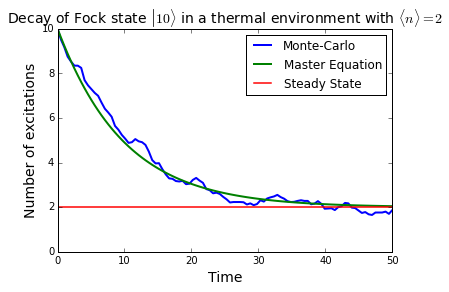

In [15]:
N = 20  # number of basis states to consider
a = destroy(N)
H = a.dag() * a
psi0 = basis(N, 10)  # initial state
kappa = 0.1  # coupling to the bath
c_op_list = []
n_th_a = 2  # temperature with average of 2 excitations
rate = kappa * (1 + n_th_a)
c_op_list.append(np.sqrt(rate) * a)  # decay operators
rate = kappa * n_th_a
c_op_list.append(np.sqrt(rate) * a.dag())  # excitation operators

#Steady state solution
final_state = steadystate(H, c_op_list)
fexpt = expect(a.dag() * a, final_state)

#Dynamical solutions
tlist = linspace(0, 50, 100)
mcdata = mcsolve(H, psi0, tlist, c_op_list, [a.dag() * a], ntraj=100)
medata = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a])

#Plot results
figure(figsize=(6,4))
plot(tlist, mcdata.expect[0], tlist, medata.expect[0], lw=2)
axhline(y=fexpt, color='r', lw=1.5) # ss expt. value as horiz line (= 2)
ylim([0, 10])
xlabel('Time', fontsize=14)
ylabel('Number of excitations', fontsize=14)
legend(('Monte-Carlo', 'Master Equation', 'Steady State'))
title('Decay of Fock state $\left|10\\rangle\\right.$' +
      ' in a thermal environment with $\langle n\\rangle=2$', fontsize=14)
show()

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/guide.css", "r").read()
    return HTML(styles)
css_styling()